---

## Avances de Trabajo de Obteción de Grado <img align="right" width="100" src=https://www.iteso.mx/lfportal-publico-theme/images/img/logos/Logo-ITESO-MinimoV.png>


### Luis Guerrero  luis.guerrero@iteso.mx

2022-05-06

---

### Sinodales:

#### Diana Paola Montoya
#### César Nuñez

### Asesor:

#### Juan Francisco Muñoz




<img align="right" width="100" src=https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png>





Repositorio de Código y avances 

https://github.com/lagrom/tog


Las definiciones y alcances de este proyecto estan en el archivo PresentacionAvances.pdf, que se encuentra en el repositorio del TOG.

Este código incluye los avances en la exploración análitica de datos, este proceso se basa en dos scripts, mencionados abajo. 

In [10]:
from zlib import decompressobj
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import chart_studio.plotly as py
from IPython.display import display
import time
import sys
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline  

Para la de extracción de datos se necesitan el archivo data.py y el TOG_1.py, el primero es la función que se conecta a binance y 
baja la informacón. Puede bajar información tantos de orderbooks como public trades.
En el archivo TOG1, se ontieben los datos den formato de diccionario, de ahí los transforma a un DataFrame, Por último los almacena
en formato parquet.

In [11]:
orderbook = pd.read_parquet('orderbook_1hour.parquet')

Después de la extracción de datos los importo hago un despliegue de sus mediciones simples:

In [12]:
# Reviso la distribucion de los datos
orderbook.describe()

,bid_vol,bid_price,ask_price,ask_vol
count,832400.000000,832400.000000,832400.000000,832400.000000
mean,4.237483,2771.643536,2775.088105,3.484570
std,9.821905,12.111330,12.066207,6.663544
min,0.000100,2753.190000,2755.500000,0.000100
25%,0.181200,2760.900000,2764.390000,0.386900
50%,1.495500,2765.650000,2769.540000,1.453900
75%,3.929300,2787.280000,2789.860000,3.616400
max,294.479300,2795.350000,2799.550000,237.670900


También verifico que no tenga datos Nan.

In [13]:
# Verifico si hay NaN
orderbook.isna().sum()

bid_vol      0
bid_price    0
ask_price    0
ask_vol      0
timestamp    0
dtype: int64

Como primer paso de exploración de datos (EDA), hago boxplot de los precios y volumenes, En el que se puede apreciar 
que aparecen algunos outliers, en pasos posteriores tengo que invesitgar si aportan al modelo y tomar la decisión de si los elimino.

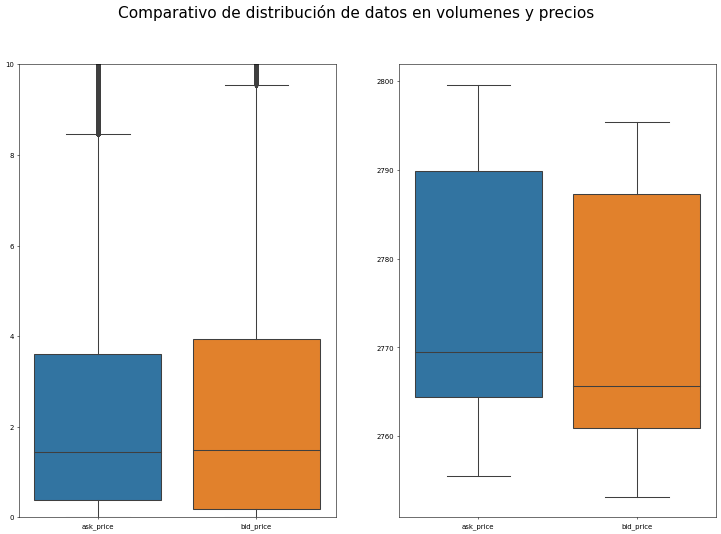

In [14]:
f, axes = plt.subplots(1, 2, figsize=(18, 12), dpi=50, sharex=True)
plt.suptitle(
    'Comparativo de distribución de datos en volumenes y precios', fontsize=22)
sns.boxplot(data=orderbook[['ask_vol', 'bid_vol']],
            ax=axes[0]).set(ylim=(0, 10))
sns.boxplot(data=orderbook[['ask_price', 'bid_price']], ax=axes[1])
plt.show()

Para seguir adelante y hacer el resampling de la información, convierto el timestamp en índice.

In [ ]:
orderbook = orderbook.set_index('timestamp')

En el proceso de resampleo a segundos incluyo la función OHLC que rea el open, high, low y close de cada intervalo de tiempo. El resampling lo hago para ASk, Bid y los Volumenes.

In [18]:
# Resampling



data_ask = orderbook['ask_price'].resample('S').ohlc()
data_ask.isna().sum()
data_ask.fillna(method='ffill', inplace=True)
data_ask.isna().sum()
data_bid = orderbook['bid_price'].resample('S').ohlc()
data_bid.isna().sum()
data_bid.fillna(method='ffill', inplace=True)
data_bid.isna().sum()
# data_bid[(data_bid.open==False)]


vol = orderbook[['bid_vol', 'ask_vol']].resample('S').sum()
vol.isna().sum()
vol[vol['bid_vol'] == 0].count()
vol.replace(to_replace=0, method='ffill', inplace=True)
vol[vol['bid_vol'] == 0].count()

data_ask_bid = pd.concat([data_ask, data_bid, vol],
                         axis=1, keys=['Ask', 'Bid', 'Volume'])

data_ask_bid


Ask                                 Bid           \
                        open     high      low    close     open     high   
timestamp                                                                   
2022-05-01 18:33:40  2790.78  2794.43  2790.78  2794.34  2790.77  2790.77   
2022-05-01 18:33:41  2790.78  2794.34  2790.78  2794.34  2790.77  2790.77   
2022-05-01 18:33:42  2790.78  2794.43  2790.41  2793.63  2790.77  2790.77   
2022-05-01 18:33:43  2790.40  2793.98  2790.40  2793.98  2790.39  2790.39   
2022-05-01 18:33:44  2790.40  2794.00  2790.40  2793.99  2790.39  2790.39   
...                      ...      ...      ...      ...      ...      ...   
2022-05-01 19:33:35  2763.92  2767.99  2763.92  2767.90  2763.91  2763.91   
2022-05-01 19:33:36  2763.92  2767.90  2763.92  2767.90  2763.91  2763.91   
2022-05-01 19:33:37  2763.92  2767.78  2763.92  2767.78  2763.91  2763.91   
2022-05-01 19:33:38  2763.92  2768.00  2763.92  2768.00  2763.91  2763.91   
2022-05-01 19:33:39  2763.92  2767.90  2763.92  2767.68  2763.91  2763.91   

                                          Volume             
                         low    close    bid_vol    ask_vol  
timestamp                                                    
2022-05-01 18:33:40  2788.15  2788.15  1627.8082   914.4023  
2022-05-01 18:33:41  2788.10  2788.10  1678.5360   920.6918  
2022-05-01 18:33:42  2787.40  2787.40   685.8379   804.8613  
2022-05-01 18:33:43  2787.27  2787.30   886.4243  1284.4150  
2022-05-01 18:33:44  2787.38  2787.39   680.0629   888.3855  
...                      ...      ...        ...        ...  
2022-05-01 19:33:35  2760.71  2760.73  1459.0296   753.6902  
2022-05-01 19:33:36  2760.75  2760.75   933.5508   524.4330  
2022-05-01 19:33:37  2760.74  2760.75  1406.5758   782.7452  
2022-05-01 19:33:38  2760.74  2760.75   963.1738   510.6757  
2022-05-01 19:33:39  2760.75  2760.75   946.4707   522.2203  

[3600 rows x 10 columns]

Defino mi variablo objetivo: Close - Open

In [26]:
# Target
data_ask_bid['Target'] = data_ask_bid[(
    'Ask', 'close')] - data_ask_bid[('Ask', 'open')]


Defino las variables adicionales de decisión (Features):
* Mid Price
* Spread
* Volume Imbalance
* Weighted mid price
* VWAP

In [27]:
# Features

# MidPrice
data_ask_bid['mid_price'] = (
    data_ask_bid[('Bid', 'high')] + data_ask_bid[('Ask', 'low')])/2

# Spread
data_ask_bid['spread'] = abs(
    (data_ask_bid[('Bid', 'high')] - data_ask_bid[('Ask', 'low')]))

# Volume Imbalance
data_ask_bid['Vol_Imbalance'] = abs(
    data_ask_bid[('Volume', 'bid_vol')] - data_ask_bid[('Volume', 'ask_vol')])

# Weighted mid price
data_ask_bid['Wghtd_mid_price'] = ((data_ask_bid[('Ask', 'low')]*data_ask_bid[('Volume', 'bid_vol')]) + (data_ask_bid[(
    'Bid', 'high')]*data_ask_bid[('Volume', 'ask_vol')]))/(data_ask_bid[('Volume', 'bid_vol')] + data_ask_bid[('Volume', 'ask_vol')])

# Volume weighted average price
data_ask_bid['vwap'] = ((data_ask_bid[('Ask', 'low')]*data_ask_bid[('Volume', 'ask_vol')]) + (data_ask_bid[(
    'Bid', 'high')]*data_ask_bid[('Volume', 'bid_vol')]))/(data_ask_bid[('Volume', 'bid_vol')] + data_ask_bid[('Volume', 'ask_vol')])

data_ask_bid.head()

Ask                                 Bid           \
                        open     high      low    close     open     high   
timestamp                                                                   
2022-05-01 18:33:40  2790.78  2794.43  2790.78  2794.34  2790.77  2790.77   
2022-05-01 18:33:41  2790.78  2794.34  2790.78  2794.34  2790.77  2790.77   
2022-05-01 18:33:42  2790.78  2794.43  2790.41  2793.63  2790.77  2790.77   
2022-05-01 18:33:43  2790.40  2793.98  2790.40  2793.98  2790.39  2790.39   
2022-05-01 18:33:44  2790.40  2794.00  2790.40  2793.99  2790.39  2790.39   

                                          Volume            mid_price spread  \
                         low    close    bid_vol    ask_vol                    
timestamp                                                                      
2022-05-01 18:33:40  2788.15  2788.15  1627.8082   914.4023  2790.775   0.01   
2022-05-01 18:33:41  2788.10  2788.10  1678.5360   920.6918  2790.775   0.01   
2022-05-01 18:33:42  2787.40  2787.40   685.8379   804.8613  2790.590   0.36   
2022-05-01 18:33:43  2787.27  2787.30   886.4243  1284.4150  2790.395   0.01   
2022-05-01 18:33:44  2787.38  2787.39   680.0629   888.3855  2790.395   0.01   

                    Vol_Imbalance Wghtd_mid_price         vwap Target  
                                                                       
timestamp                                                              
2022-05-01 18:33:40      713.4059     2790.776403  2790.773597   3.56  
2022-05-01 18:33:41      757.8442     2790.776458  2790.773542   3.56  
2022-05-01 18:33:42      119.0234     2790.604372  2790.575628   2.85  
2022-05-01 18:33:43      397.9907     2790.394083  2790.395917   3.58  
2022-05-01 18:33:44      208.3226     2790.394336  2790.395664   3.59

Verifíco una vez mas que no tenga NaN, esto por si hubo algun error en los cálculos de las variables, que los genere.
 Y analizo la información de las estadísticas basicas de la variable objetivo.

In [29]:
orderbook1 = data_ask_bid.copy()

orderbook1.isna().sum()

orderbook1[('Volume', 'ask_vol')].sort_values()

orderbook1.shape

orderbook1['Target'].describe()

count    3600.000000
mean        3.928817
std         0.638000
min         2.450000
25%         3.510000
50%         3.810000
75%         4.220000
max         8.420000
Name: Target, dtype: float64

Comparo el Ask-high, Bid-Low y el vwap, para comprobar que la última siempre se mantiene en medio de ambas y asi conluir que esta bien calculada.

También gráfico mi variable objetivo y los volúmenes.


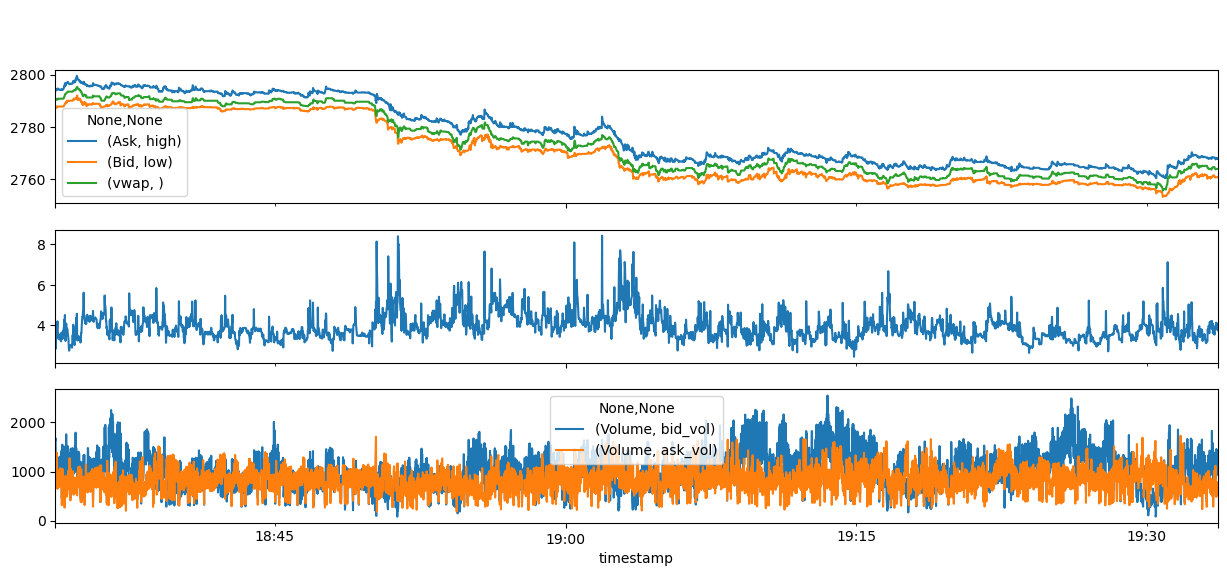

In [34]:
f, axes = plt.subplots(3, 1, figsize=(18, 12), dpi=100, sharex=True)
plt.suptitle(
    '  ', fontsize=22)

orderbook2 = orderbook1[[('Ask', 'high'), ('Bid', 'low'), ('vwap', '')]]
orderbook2.plot(figsize=(15, 6), ax=axes[0])

orderbook1['Target'].plot(figsize=(15, 6), ax=axes[1])

orderbook3 = orderbook1[[('Volume', 'bid_vol'), ('Volume', 'ask_vol')]]
orderbook3.plot(figsize=(15, 6), ax=axes[2])

plt.show()

Empiezo ahora a probar con una regresión simple algunas variables: Mid Price vs Ask-High

In [35]:
X = sm.add_constant(orderbook1['mid_price'])
model = sm.OLS(orderbook1[[('Ask', 'high')]], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Ask_high   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.262e+06
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        23:05:25   Log-Likelihood:                -3529.8
No. Observations:                3600   AIC:                             7064.
Df Residuals:                    3598   BIC:                             7076.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4436      2.472      0.179      0.8

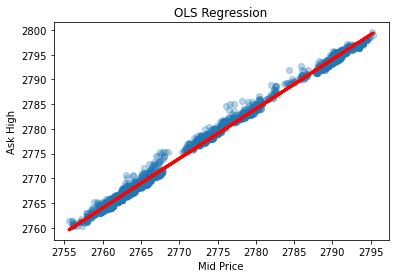

In [36]:
plt.scatter(orderbook1['mid_price'], orderbook1[[('Ask', 'high')]], alpha=0.3)
y_predict = results.params[0] + results.params[1]*orderbook1['mid_price']
plt.plot(orderbook1['mid_price'], y_predict, linewidth=3, color='r')
plt.xlabel('Mid Price')
plt.ylabel('Ask High')
plt.title('OLS Regression')

plt.show()

Ya hora el VWMAP con Ask-Close

In [37]:
X = sm.add_constant(orderbook1['vwap'])
model = sm.OLS(orderbook1[[('Ask', 'close')]], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Ask_close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.405e+06
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        23:06:05   Log-Likelihood:                -3338.7
No. Observations:                3600   AIC:                             6681.
Df Residuals:                    3598   BIC:                             6694.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0199      2.344     -0.435      0.6

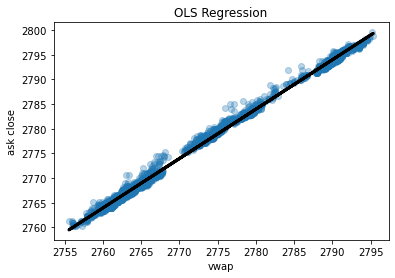

In [38]:
plt.scatter(orderbook1['vwap'], orderbook1[[('Ask', 'close')]], alpha=0.3)
y_predict = results.params[0] + results.params[1]*orderbook1['vwap']
plt.plot(orderbook1['vwap'], y_predict, linewidth=3, color='k')
plt.xlabel('vwap')
plt.ylabel('ask close')
plt.title('OLS Regression')

plt.show()

AHora, hago el primer análisis de correlación, es interesante ver como existe correlación en tre las variables calculadas y las originales, 
lo cual es de esperar, pero no hay a simple vista corelación entre el volumen y el precio. Lo cual se puede llegar a deber a la cantidad
limitada de datos.

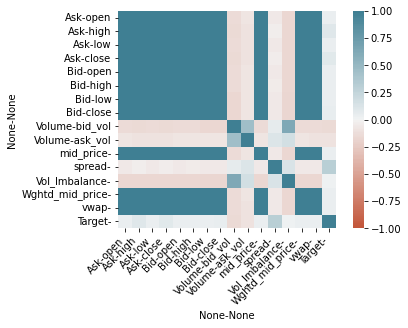

In [39]:
corr = orderbook1.corr()
corr

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Gráfica de AutoCorrelación e la variable objetivo.

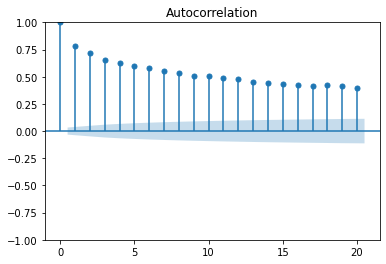

In [40]:


plot_acf(orderbook1['Target'], lags=20)
plt.show()

Gráfica de AutoCorrelación parcial e la variable objetivo.

/Users/luisaguerrerom/opt/anaconda3/envs/vscode/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


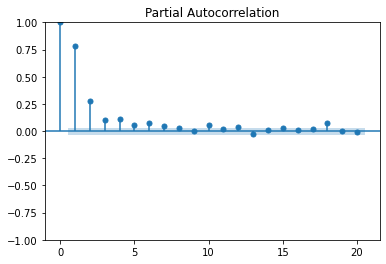

In [41]:
plot_pacf(orderbook1['Target'], lags=20)
plt.show()

Ejecuto una diferenciación para ver si desplazando la serie puedo ver su estacionalidad, se puede apreciar que la serie no es estacionaria.

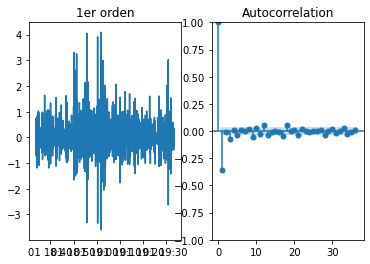

In [42]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1er orden")
ax1.plot(orderbook1.Target.diff())

ax2 = f.add_subplot(122)
plot_acf(orderbook1.Target.diff().dropna(), ax=ax2)

plt.show()

Una segunda diferenciación confirma la no estacionalidad.

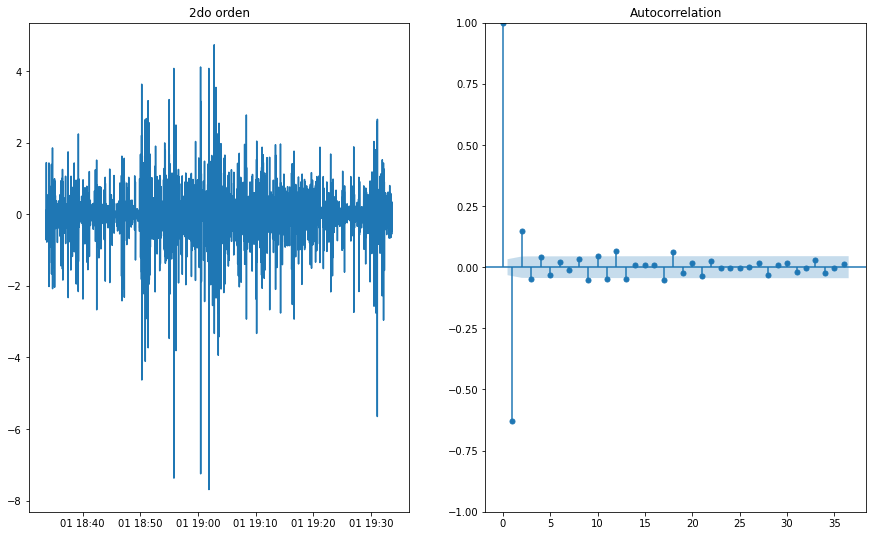

In [50]:
f = plt.figure(figsize=(15, 9))
ax1 = f.add_subplot(121)
ax1.set_title("2do orden")
ax1.plot(orderbook1.Target.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(orderbook1.Target.diff().diff().dropna(), ax=ax2)

plt.show()

Aplico una descompocisión aditiva y multiplicatiova, se puede observar que no se obtiene información de los residuales,
se puede apreciar que la serie no es estacionaria.

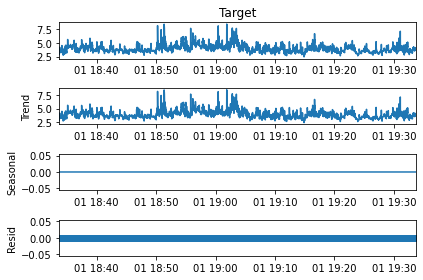

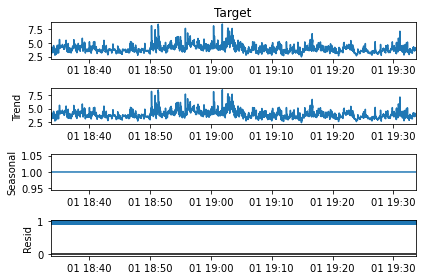

In [52]:
# Simple multiplicative decomposition
result = seasonal_decompose(orderbook1.Target, model='additive', period=1)
fig = result.plot()
plt.show()

result = seasonal_decompose(orderbook1.Target, model='multiplactive', period=1)
fig = result.plot()
plt.show()

Por último uso un Arima, los parametros los movi en varias versiones hasta tener un mejor desempeño, en esta pimera iteración del trabajo,
en las siguientes entregas  icluire mas pruebas con paramtros obtenidos de las acf y pac asi como la función de autoarima.

In [45]:
arima_model = ARIMA(orderbook1.Target, order=(2, 1, 3))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Target   No. Observations:                 3600
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1594.284
Date:                Thu, 05 May 2022   AIC                           3200.569
Time:                        23:09:25   BIC                           3237.699
Sample:                    05-01-2022   HQIC                          3213.801
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1318      0.014     -9.243      0.000      -0.160      -0.104
ar.L2          0.8482      0.015     57.153      0.000       0.819       0.877
ma.L1         -0.3649      0.018    -20.358      0.0

/Users/luisaguerrerom/opt/anaconda3/envs/vscode/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


En el resultado del modelo Arima,de manera gráfica, podemos apreciar que de acuerdo a la grafica de qqplot los datos no son 
normales, lo cual lo podemos apreciar también en el histograma y las gráficas de densidad.

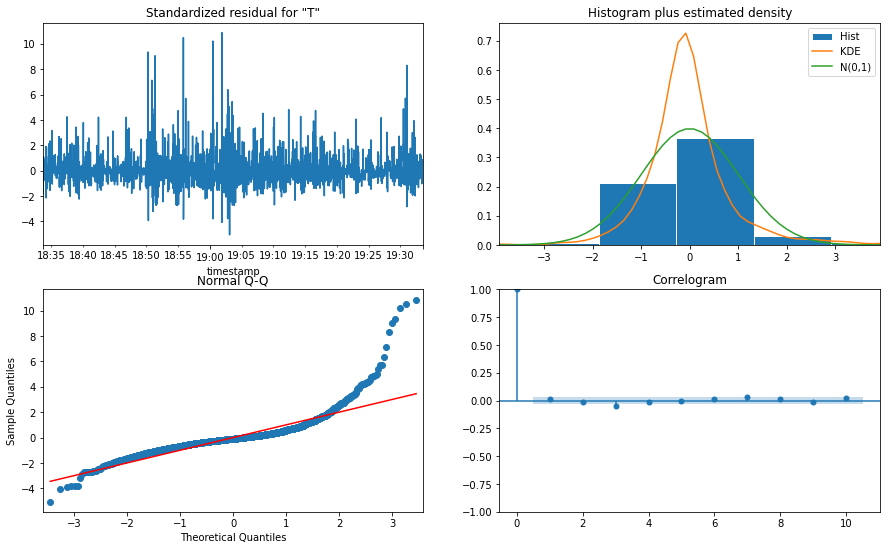

In [46]:
fig = model.plot_diagnostics(figsize=(15, 9))
plt.show()